##  Examination of Demographic Features that Influence Party Affiliation, and Selecting Features for Modelling and Prediction of Party Preference 
### Overview
 
The draft report published on June 15th (Draft North Carolina Voter Demographics Influence on Party Affiliation) yielded several questions that will be answered in this new report.  In addition, several recommendations were made for enhancing this analysis. I have listed these below: 

0. Questions
    1. Re-run the analysis to just characterize non-black registered voters. COMPLETE and provided separately
    2. Explore racial makeup of house districts. COMPLETE and provided seperately
        1. Visualize this in a heat map (follow-on activity).
1. Recommendations
    1. Use a more granular measure (zip code for now) to characterize geographic location
        1. Ultimate goal will be to use latitude and longitude
    2. Focus on parametric modelling (logistic regression) so that parameters (feature weights) can be used for analysis.
    3. Create interaction features (combinations of two or more existing features or powers of continuous features) to search for additional influencing factors.
    4. Eliminate age groupings and make age a floating point feature. 
    5. Use a more formal feature selection process (e.g. forward and/or backward selection, L1 Normalization)
    
    






### Section A: Preparation, Pulling Data from the Database, and Cleaning the Data

In [1]:
#First set everthing up
import pyodbc
import graphlab as gl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import local #server information and credentials
from pullODBC import pullODBC 
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 7
plt.tight_layout;
plt.rc('xtick', labelsize=7) 
plt.rc('ytick', labelsize=7) 

Display everything in full screen

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Set up the fields that I need to pull from the database.  This is long list that will be reduced to most influential set.

In [3]:
#Set up the fields that I need to pull from the database 
fields = '["birth_age"], ["gender_code"], ["race_code"], ["ethnic_code"],["party_cd"], ["status_cd"], ["zip_code"], ["nc_house_abbrv"], ["birth_state"], ["precinct_abbrv"], ["drivers_lic"], ["municipality_abbrv"], ["county_desc"], ["nc_senate_abbrv"], ["cong_dist_abbrv"],["registr_dt"]'
print fields

["birth_age"], ["gender_code"], ["race_code"], ["ethnic_code"],["party_cd"], ["status_cd"], ["zip_code"], ["nc_house_abbrv"], ["birth_state"], ["precinct_abbrv"], ["drivers_lic"], ["municipality_abbrv"], ["county_desc"], ["nc_senate_abbrv"], ["cong_dist_abbrv"],["registr_dt"]


Only registered, active and inactive voters affiliated as democratic or republican will be pulled for this analysis.   Below I set up my filtering condition to reflect this.  

In [4]:
condition1 = '["status_cd"] = ' + local.single_double_quote + 'A' + local.double_single_quote
condition2 = '["status_cd"] = ' + local.single_double_quote + 'I' + local.double_single_quote
condition3 = '["county_desc"] = ' + local.single_double_quote + 'Wake' + local.double_single_quote
condition4 = '["party_cd"] = ' + local.single_double_quote + 'DEM' + local.double_single_quote
condition5 = '["party_cd"] = ' + local.single_double_quote + 'REP' + local.double_single_quote
condition = "(" + condition1 + " OR " + condition2 + ")" + " AND "  + "(" + condition4 + " OR " + condition5 + ")"
print condition

(["status_cd"] = '"A"' OR ["status_cd"] = '"I"') AND (["party_cd"] = '"DEM"' OR ["party_cd"] = '"REP"')


Pull the data from my local database

In [5]:
demographics=pullODBC(local.driver,
                      local.server,
                      local.database,
                      local.username,
                      local.password,
                      local.table,
                      fields,
                      condition)

Get rid of all the double quotes from the dataframe

In [6]:
demographics.columns = demographics.columns.str.strip('"')
for i, col in enumerate(demographics.columns):
    demographics.iloc[:, i] = demographics.iloc[:, i].str.replace('"', '')
print demographics.head()

  birth_age gender_code race_code ethnic_code party_cd status_cd zip_code  \
0        93           F         W          NL      DEM         A    27215   
1        59           M         W          NL      REP         A    27253   
2        68           F         W          NL      REP         A    27217   
3        76           M         W          UN      REP         A    27217   
4        28           M         W          NL      DEM         A    27302   

  nc_house_abbrv birth_state precinct_abbrv drivers_lic municipality_abbrv  \
0            064          SC           03N2           Y                ELO   
1            063          WV            103           Y                SWE   
2            063          PA             13           Y                      
3            063          IA             13           Y                      
4            063          IN            103           N                      

  county_desc nc_senate_abbrv cong_dist_abbrv  registr_dt  
0    ALA

Save the total number of active, democratic and republican voters to raw-len and print. We will use this later after cleaning to calculate how many rows we have deleted

In [7]:
raw_len=len(demographics)
print "The number of rows pulled from the database is " + str(raw_len)

The number of rows pulled from the database is 4692494


Create a generic function to change blank fields to NaN for all categorical fields except birth_state and municipality_abbrv

In [8]:
def fix_blanks_NaN(x):
    if x == "":
        return np.nan
    elif x == " ":
        return np.nan
    else:
        return x

Create a generic function to change blank fields to None for birth_state and municipality_abbrv

In [9]:
def fix_blanks(x):
    if x == "":
        return "None"
    elif x == " ":
        return "None"
    else:
        return x

In [10]:
demographics['birth_state'] = demographics['birth_state'].apply(fix_blanks) # change blanks to "None" in birth_state
demographics['municipality_abbrv'] = demographics['municipality_abbrv'].apply(fix_blanks) # change blanks to "None" in municipality_abbrv
demographics['gender_code'] = demographics['gender_code'].apply(fix_blanks_NaN) # change blanks to NaN in gender_code
demographics['race_code'] = demographics['race_code'].apply(fix_blanks_NaN) # etc.
demographics['ethnic_code'] = demographics['ethnic_code'].apply(fix_blanks_NaN) 
demographics['zip_code'] = demographics['zip_code'].apply(fix_blanks_NaN)
demographics['nc_house_abbrv'] = demographics['nc_house_abbrv'].apply(fix_blanks_NaN)
demographics['birth_state'] = demographics['birth_state'].apply(fix_blanks_NaN) 
demographics['precinct_abbrv'] = demographics['precinct_abbrv'].apply(fix_blanks_NaN) 
demographics['drivers_lic'] = demographics['drivers_lic'].apply(fix_blanks_NaN) 
demographics['county_desc'] = demographics['county_desc'].apply(fix_blanks_NaN) 
demographics['nc_senate_abbrv'] = demographics['nc_senate_abbrv'].apply(fix_blanks_NaN) 
demographics['cong_dist_abbrv'] = demographics['cong_dist_abbrv'].apply(fix_blanks_NaN) 
demographics['registr_dt'] = demographics['registr_dt'].apply(fix_blanks_NaN)

Clean the data by dropping rows with missing data and print a summary

In [11]:
demographics.dropna(inplace=True, how='any') #drop all rows with NaN
clean_len=len(demographics) #how many rows to I have left?
difference = raw_len - clean_len #how many rows have I dropped?
fraction = float(difference)/float(raw_len) #what fraction of rows have I dropped?
print "The number of rows I have dropped is " + str(difference) 
print "The number of rows remaining in the database is " + str(clean_len)
print "The precentage of rows that I have dropped is: " + str('{:.3%}'.format(fraction))

The number of rows I have dropped is 2091
The number of rows remaining in the database is 4690403
The precentage of rows that I have dropped is: 0.045%


convert birth_age to a float and registr_dt to datetime

In [12]:
demographics['birth_age'] = demographics['birth_age'].astype('float64')
demographics['registr_dt'] = pd.to_datetime(demographics['registr_dt'])

### Section B: Initial Modelling and Evaluation for Overfiitting

We need to determine the "Majority Classifier".  This is the percentage of the entire measured population that is a member of the majority class (either democratic or republican).  This is the baseline for measuring our model performance using "accuracy" since it is the performance we would achieve if we predicted every member of the population to be in the majority class

In [13]:
majority = demographics.groupby(['party_cd'])['party_cd'].count()/demographics.groupby(['party_cd'])['party_cd'].count().sum()
print majority

party_cd
DEM    0.562424
REP    0.437576
Name: party_cd, dtype: float64


###### The majority class with all voters is "democratic" and the accuracy of the "Majority Classifier" is 56.2%.  This will be our baseline for measuring model accuracy.


In [14]:
mean_age = demographics['birth_age'].mean()
#demographics['birth_age_c'] = demographics['birth_age'] - mean_age

Now we will implement recommendations 2A, 2B, and 2C: 

0. Use a more granular measure (zip code for now) to characterize geographic location
0. Focus on the parametric analysis (logistic regression)so that parameters (feature weights) can be used for analysis.
0. Create interaction features (combinations of two or more existing features) to search for additional influencing factors.

Let's start by creating interaction variables for some pairs of categorical variables (2C):

0. Race/Gender
0. Race/Ethnicity
0. Gender/Ethnicity

Each of these new variables will use a two or three letter code 

I also create the age_squared, age_cubed, days_since_registration, and urban_rural variables



In [15]:
def convert_to_float(x): # function to convert a timedelta object to a float
    return x.total_seconds()/(60*60*24)

In [16]:
def urban_or_rural(x): # function to change a municipality code to "Urban" or "Rural"
    if x == "None":
        return "Rural"
    else:
        return "Urban"

In [17]:
demographics['race_gender'] = demographics['race_code'] + demographics ['gender_code']
demographics['race_ethnicity'] = demographics['race_code'] + demographics['ethnic_code']
demographics['gender_ethnicity'] = demographics['gender_code'] + demographics ['ethnic_code']
demographics['age_squared'] = (demographics['birth_age'])**2
demographics['age_cubed'] = (demographics['birth_age'])**3
now = pd.to_datetime('today') # get today's data
demographics['days_since_registration'] = now - demographics['registr_dt'] # get days since registration as a timedelta object
demographics['days_since_registration'] = demographics['days_since_registration'].apply(convert_to_float) # convert to float
demographics['urban_rural'] = demographics['municipality_abbrv'].apply(urban_or_rural) # new field with "Urban" and "Rural"
demographics = demographics.drop(['registr_dt'], 1) # We no longer need registr_dt


##### Features
Initially, I select all possible features that could impact party preference

In [18]:
initial_features = ['birth_age', 
                    'gender_code', 
                    'race_code', 
                    'ethnic_code', 
                    'zip_code', 
                    'nc_house_abbrv', 
                    'birth_state', 
                    'precinct_abbrv', 
                    'drivers_lic', 
                    'municipality_abbrv', 
                    'county_desc', 
                    'nc_senate_abbrv', 
                    'cong_dist_abbrv', 
                    'race_gender', 
                    'race_ethnicity', 
                    'gender_ethnicity',
                    'age_squared', 
                    'age_cubed',
                    'days_since_registration',
                    'urban_rural'] 
                    

##### For analysis of coefficients we need to remove "outliers"

To remove any "outliers", I need counts for each value of a feature.  If any value of a feature has very few observations (via threshold variable below), we will delete it from the data.  The following code removes these from the dataframe.  

The reason this needs to be done is because feature values with very few observations can generate logistic regression coefficients that are extremely large.  Since we'll be using coefficient values to determine the importance of features, not doing this could distort the analysis. However, when doing predictions, we will use all the feature values.

In [19]:
from collections import Counter

threshold = 120 # if fewer than 120 voters have a feature value, remove them from the data
feature_values_to_remove = list() # create an empty list to hold all the feature values to remove
# Don't remove any of the continuous features
explore_features = [feature for feature in initial_features if ((feature != "birth_age") & (feature != "age_squared") & (feature != "age_cubed") & (feature != "days_since_registration"))]



for feature in explore_features: # first identifiy the feature values to be remove
    hist_series = np.array(demographics[feature].astype('string')) # create a series consisiting of only the values of the feature
    counts = Counter(hist_series) # create a dictionary with key equal to feature value, and value equal to number of occurances
    df = pd.DataFrame.from_dict(counts, orient='index') # convert the dictionary into a data frame
    df.sort_values(0,axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last') # sort for exploration
    df.index.name = 'value' # make the index a column
    df.reset_index(inplace=True) # reset the data frame indexes
    df.columns = ['value','count'] # name the columns
    to_remove = df.query('count < ' + str(threshold))['value'] # create a series containing the feature values with < threshold values 
    feature_values_to_remove.append(to_remove) # append these to the list of feature values to remove
    #print "Feature values to be removed are " + str(feature_values_to_remove)


for feature in explore_features:
    feature_index = pd.Index(explore_features).get_loc(feature) # get the index of the feature
    values_to_remove = feature_values_to_remove[feature_index] # now pull this feature's "values to remove" from the list
    #print "The values to be removed are" + str(values_toremove)
    for value in values_to_remove: # iterate to remove each value
        demographics = demographics[demographics[feature] != value]

out_len = len(demographics)
print "The number of outliers that were removed from the data is " + str(clean_len-out_len)

The number of outliers that were removed from the data is 4971


In [20]:
# For scalability, we need to convert our data into a GraphLab SFrame

demographicsS=gl.SFrame(demographics)
demographicsS['birth_age']=demographics['birth_age'].astype('float')

This non-commercial license of GraphLab Create for academic use is assigned to scottsmi@live.unc.edu and will expire on May 15, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Windows\SERVIC~2\LOCALS~1\AppData\Local\Temp\graphlab_server_1499380065.log.0


##### Logistic Classifier 
My deep dive analysis will utilize a "Logistic" classifier.  This is a parametric classifier.  The column 'party_cd' will be used as our target for classification.  The classification "REP" will be considered a 'positive' and the classification "DEM" will be considered a 'negative'.  This choice is arbitrary.

We will start by dividing our full data set of registered democrats and republicans into two partitions.  The first partition will be called the "training" data set and will contain a randomly selected subset of 80% of the entire population of registered democrats and republicans.  This data will be used to create our logistic regression model.

The second partition will be called the "test" data set and will contain the remaining 20% of the entire population of registered democrats and republicans.  Once the logistic regression model is created using the "training" data set, this model will attempt to predict the party affiliation of voters in the "test" data set. We will measure the performance of the model using "accuracy" of predictions, which is the percent of voters correctly identified in the "test" data set as either republican or democratic.  We are assuming that the "cost" of predicting a republican as a democrat or vice-versa is the same, so accuracy is an adequate measure of performance.  Note that there are other measures of model performance that we could use if the "cost" of an incorrect prediction was different in each case (e.g. "precision", "recall") but this is not necessary at this point.

###### Avoiding Overfitting: Feature Selection via L1 Regularization
The logistic classifier has two tuning parameters, l1_penalty and l2_penalty.  The l2_penalty could potentially shrink  coefficient values but does not eliminate features.  For now we will leave this penalty at 0.01 for numerical stability and only revisit l2_penalty if coefficient values are large. We will focus on the l1_penalty, which eliminates features to avoid over-fitting. This  "L1 Regularization"  could  eliminate the least important features by setting their coefficients to 0.  This will minimize model complexity and prevent over-fitting.   

Split the data into training/validation data(80%) and test data (20%), and shuffle the training/validation data

In [21]:
train_valid, test = demographicsS.random_split(.8)# split 80/20
train_valid_shuffled = gl.toolkits.cross_validation.shuffle(train_valid)#shuffle the 80% so we can validate

We will now use k-fold cross validation to enable us to iterate through the various L1 penalties to select the best value (the value that minimizes the validation error).  

The first thing that we do is create a function that takes as input the number of folds (k), the l1_penalty value (penalty), the training/validation data (data), the feature for classification (output) and the features to be used in the model (feature_list) and returns the mean error across the k folds.  In this case, we will define error to be 1 minus the accuracy of each model

In [22]:
def k_fold_cross_validation_logistic_classifier(k, penalty, data, output, features_list):
    n = len(data) #n is the number of records in the training/validation data
    error = 0 #initialize error to 0
    for i in xrange(k):# we now iterate over each of the k partions
        #first compute start and end of the validation set
        start = (n*i)/k
        end = (n*(i+1))/k-1
        #create validation set
        validation = data[start:end+1]
        #create training set from the rest of the data
        top = train_valid_shuffled[0:start]
        bottom = train_valid_shuffled[end+1:n]
        training = top.append(bottom)
        #train logistic classifier
        model = gl.logistic_classifier.create(training, target=output, features=features_list, 
                                              validation_set=None, l1_penalty=penalty, 
                                              verbose=False, max_iterations=10000)
        #compute validation error
        accuracy = model.evaluate(validation)['accuracy'] #pull out accuracy
        results = 1 - accuracy #1 minus accuracy is error
        error += results #add this to the cumulative error sum
    return error/k  #return the average validation error 

##### Selecting the best L1 Penalty 

Now I'm going to add all the features into my model to start, and iterate from L1 Penalty Values from 0.1 to 10,000 and see if I can improve model performance by removing some features.  Because of the large number of observations, we will only do 2-fold cross-validation.

In [23]:
spread = np.logspace(-1,4, num=20) # I will iterate from 0.1 to 10,000 in 20 steps  
max_error = 1 # initalize my maximum error to 1
best_l1 = 0 # initialize my best L1 penatly to 0
l1_penalty_range = list() # create an empty list for  all the l1 penalties
error_range = list() # create an empty list for all the errors
for penalty in spread:
    error = k_fold_cross_validation_logistic_classifier(3,penalty,train_valid_shuffled,'party_cd',initial_features)
    print penalty, error
    l1_penalty_range.append(penalty)
    error_range.append(error)
    if error < max_error:
        max_error = error
        best_l1 = penalty
print "The L1 Penatly that produces the lowest error is: " + str(best_l1) + " and the error is:  "+ str(max_error)

0.1 0.246483829903
0.183298071083 0.246484096714
0.335981828628 0.246484363525
0.615848211066 0.246483563093
1.12883789168 0.246479827738
2.06913808111 0.246478493682
3.79269019073 0.246476359192
6.95192796178 0.246487832071
12.742749857 0.246488899317
23.3572146909 0.246479294117
42.8133239872 0.246448077225
78.4759970351 0.246465153131
143.844988829 0.24646995572
263.665089873 0.246421129302
483.293023857 0.246469155304
885.86679041 0.24678399237
1623.77673919 0.247594564522
2976.35144163 0.248641264571
5455.59478117 0.251013215204
10000.0 0.254095150232
The L1 Penatly that produces the lowest error is: 263.665089873 and the error is:  0.246421129302


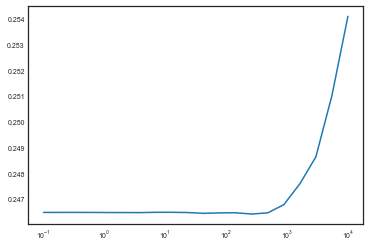

In [24]:
# Plot the l2_penalty values in the x axis and the cross-validation error in the y axis.
# Using plt.xscale('log') will make your plot more intuitive.
plt.xscale('log')
plt.plot(l1_penalty_range,error_range,'-')


The graph above indicates a very stable error of approximately .246 up until we add an L1 penatly of 1E3.   Based upon this (and consistent with the large number of observations in the dataset) we can sefely conclude that there will be no risk of overfitting.  Since regualrization biases the model, the best choice is to proceed without L1 regulariztion.  The L1 penalty will be 0.

This being said, it would still be advantageous to simplify the model if we can do so with limited reduction in accuracy.  There are two reasons to do this:

0. A simpler model will make it easier to estimate how much relative influence specific demographic factors have in party preference.  This is because complex models have features that are correlated.  This includes all the different geographic features (zip code, municipality, house district, etc.) and interation variables combined with their component variables.  
1. Increasing model complexity uses up more computer resourses and takes more time.  If we can preserve accuracy while reducing complexity, we can perform more experiments and analyses in a given amount of time (and more cost effectively).

### Section C: Detailed Modelling and Exploration of Coeffients to Estimate Influence of Demographic Factors

Before I begin my detailed analysis, I need to ensure that the logistic classifier will use a neutral reference so all coefficient will be calculated relative to this baseline.  I need to create 2 rows to put on top of the SFrame with "None" as the value of all the categorical variables.  This will select "None" as the reference value and will print all the coefficients.  I'm also putting in mean values for all continuous variables to move the intercept as close to zero as possible.  

First, we calculate the mean age of voters, and the mean number of days that they've been registered.

In [25]:
mean_age = demographics['birth_age'].mean()
mean_days = demographics['days_since_registration'].mean()

Next, we create a two-row dataframe with 'None' as the value for all categorical variables and the means as the value for all continuous variables.

In [26]:
non_vals = ['None','None'] # values to fill the fields
reference_sf = gl.SFrame({'birth_age':[mean_age, mean_age], # create a new SFrame with 2 rows and "None" for all categorical variables
                    'gender_code': non_vals, 
                    'race_code': non_vals, 
                    'ethnic_code': non_vals, 
                    'party_cd':['DEM','REP'], 
                    'status_cd':['A','A'],
                    'zip_code': non_vals, 
                    'nc_house_abbrv': non_vals, 
                    'birth_state': non_vals, 
                    'precinct_abbrv': non_vals, 
                    'drivers_lic': non_vals, 
                    'municipality_abbrv': non_vals, 
                    'county_desc': non_vals, 
                    'nc_senate_abbrv': non_vals, 
                    'cong_dist_abbrv': non_vals, 
                    'race_gender': non_vals, 
                    'race_ethnicity': non_vals, 
                    'gender_ethnicity': non_vals, 
                    'age_squared' : [mean_age**2, mean_age**2],
                    'age_cubed' : [mean_age**3,mean_age**3],
                    'days_since_registration' : [mean_days, mean_days],
                    'urban_rural' : non_vals})

# not used new_demographicsS = reference_sf.append(demographicsS) # append the full SFrame to the bottom of this 2 row SFrame                         

Now we will run logistic regression using no L1 Penalty with all the variables

In [27]:
train_valid_shuffled_ref = reference_sf.append(train_valid_shuffled)
model = gl.logistic_classifier.create(train_valid_shuffled_ref, target='party_cd', features=initial_features, 
                                              validation_set=test, l1_penalty=0, 
                                              verbose=False, max_iterations=10000, class_weights=None)

Let's explore the model

In [28]:
model.evaluate(test)

{'accuracy': 0.754399644998944,
 'auc': 0.8332493367915788,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+--------+
 | target_label | predicted_label | count  |
 +--------------+-----------------+--------+
 |     REP      |       DEM       | 71288  |
 |     DEM      |       REP       | 158953 |
 |     DEM      |       DEM       | 368682 |
 |     REP      |       REP       | 338539 |
 +--------------+-----------------+--------+
 [4 rows x 3 columns],
 'f1_score': 0.7462402969628102,
 'log_loss': 0.47970289435500985,
 'precision': 0.6804913445844355,
 'recall': 0.8260534323019225,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+----------------+-----+--------+--------+
 | threshold |      fpr       | tpr |   p    |   n    |
 +-----------+----------------+-----+--------+--------+
 |    0.0    |      1.0       | 1.0 | 409827 | 5

The accuracy of the model is 75.4% vs. 56.2% for the majority classifier, a 19.2% improvement.  However, to get this accuracy we are using a vary complex model that costs a lot of time and computer resources.  Also, the number of correlated features makes the model difficult to analyze.

Now, let's look at all the coefficients and analyze them

In [29]:
pd.set_option('display.max_rows', 5000)
coeff_sf = model.get('coefficients')
coeff_df = coeff_sf.to_dataframe()
#coeff_pivot = pd.pivot_table(coeff_df, index=['name','index'], values=['value'],columns=['class'], aggfunc='mean', margins=False)
new_df = coeff_df.sort_values(['name','value','index'],axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
new_df.drop('stderr', axis=1, inplace=True)
new_df['abs_value'] = abs(new_df['value'])
coeff_pivot = pd.pivot_table(new_df, index=['name','value','index'], columns=None,  margins=False, values = 'abs_value')
min_max_pivot = pd.pivot_table(new_df, index = ['name'], values = ['value'], aggfunc=[np.min,np.max])
flattened = pd.DataFrame(min_max_pivot.to_records())
flattened.columns = ['feature','min_coeff','max_coeff']
flattened['spread'] = flattened['max_coeff'] - flattened['min_coeff']
flattened = flattened[flattened['feature'] != '(intercept)']
flattened = flattened[flattened['feature'] != 'birth_age']
flattened = flattened[flattened['feature'] != 'age_squared']
flattened = flattened[flattened['feature'] != 'age_cubed']
flattened = flattened[flattened['feature'] != 'days_since_registration']
flattened.sort_values(['spread'],axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')
print flattened
print coeff_pivot

               feature  min_coeff  max_coeff     spread
15      precinct_abbrv -13.762247   6.019593  19.781840
20            zip_code  -8.076146  10.327442  18.403588
12  municipality_abbrv  -3.097496  11.080179  14.177675
13      nc_house_abbrv  -4.113514   3.663273   7.776786
6          county_desc  -3.666556   2.598041   6.264597
5      cong_dist_abbrv  -1.285271   3.244103   4.529374
14     nc_senate_abbrv  -0.828878   1.249865   2.078743
17      race_ethnicity  -1.050543   0.507527   1.558070
18         race_gender  -1.061786   0.351431   1.413217
16           race_code  -0.974077   0.319722   1.293799
4          birth_state  -0.225040   0.566531   0.791571
11    gender_ethnicity  -0.336416   0.043654   0.380070
9          ethnic_code  -0.260379  -0.032543   0.227837
8          drivers_lic  -0.190174  -0.025528   0.164646
10         gender_code  -0.114940   0.026722   0.141663
19         urban_rural  -0.090964   0.006146   0.097110
                                            abs_

In [38]:
print len(coeff_pivot)

987


All of the most influential features are geographic:

0. precinct
1. zip code
2. municipality
3. nc house
4. county
5. us house
6. nc senate

Race only comes into play in the 8th, 9th, and 10th most influential features: race/gender, race/ethnicity, and race by itself. All of the other features are masked below these ten.  

Let's consider the geographic parts of the model.  Once we can use the latitude and longitude of specific addresses, we will have the most independent indicator of where a person chooses to live.  However, until we have these values, all we've got are zip codes, counties, municipalities, and several political classifiers (e.g. NC House district, US House district).  The problem with the political classifiers is that they are created using party affiliation as an input, and therefore will by definition be more partisan.  So these political classifiers will be very influential in our model. So, unless we want to analyze gerrymandering, they don't provide much information for true analysis and prediction.  In other words, a person does not choose to live in a certain congressional district; this is chosen for that person.  He or she does however choose to live in a particular county, municipality, precinct, and zip code.  

Also, the three interaction variables fully contain the information on gender, race, and ethnicity.  Therefore we should no longer need these three variables in isolation

Our baseline is 75.4%.  With the aim of simplifying the model without losing too much accuracy, let's build a model that removes the political classifiers, the municipality names, and gender, race, and ethnicity and see how much accuracy we lose. 

In [30]:
reduced_features = ['birth_age', 
                    'zip_code', 
                    'birth_state', 
                    'drivers_lic', 
                    'county_desc', 
                    'race_gender', 
                    'race_ethnicity', 
                    'gender_ethnicity',
                    'age_squared', 
                    'age_cubed',
                    'days_since_registration',
                    'urban_rural'] 
                    

In [31]:
train_valid_shuffled_ref = reference_sf.append(train_valid_shuffled)
model = gl.logistic_classifier.create(train_valid_shuffled_ref, target='party_cd', features=reduced_features, 
                                              validation_set=test, l1_penalty=0, 
                                              verbose=False, max_iterations=10000, class_weights=None)

In [32]:
model.evaluate(test)

{'accuracy': 0.7511355126927811,
 'auc': 0.8300318863986011,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+--------+
 | target_label | predicted_label | count  |
 +--------------+-----------------+--------+
 |     REP      |       DEM       | 70411  |
 |     DEM      |       REP       | 162890 |
 |     DEM      |       DEM       | 364745 |
 |     REP      |       REP       | 339416 |
 +--------------+-----------------+--------+
 [4 rows x 3 columns],
 'f1_score': 0.7442248005499199,
 'log_loss': 0.4827990079414559,
 'precision': 0.675715599654394,
 'recall': 0.8281933596371152,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+--------+--------+
 | threshold | fpr | tpr |   p    |   n    |
 +-----------+-----+-----+--------+--------+
 |    0.0    | 1.0 | 1.0 | 409827 | 527635 |
 |   1e-05   | 1.0 | 1.0 | 409827 | 5

With this first simplification, our accuracy dropped from 75.4% to 75.1%.  This is small price to pay for a much simpler model.

Let's explore the coefficients

In [33]:
pd.set_option('display.max_rows', 500)
coeff_sf = model.get('coefficients')
coeff_df = coeff_sf.to_dataframe()
#coeff_pivot = pd.pivot_table(coeff_df, index=['name','index'], values=['value'],columns=['class'], aggfunc='mean', margins=False)
new_df = coeff_df.sort_values(['name','value','index'],axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
new_df.drop('stderr', axis=1, inplace=True)
new_df['abs_value'] = abs(new_df['value'])
coeff_pivot = pd.pivot_table(new_df, index=['name','value','index'], columns=None,  margins=False, values = 'abs_value')
min_max_pivot = pd.pivot_table(new_df, index = ['name'], values = ['value'], aggfunc=[np.min,np.max])
flattened = pd.DataFrame(min_max_pivot.to_records())
flattened.columns = ['feature','min_coeff','max_coeff']
flattened['spread'] = flattened['max_coeff'] - flattened['min_coeff']
flattened = flattened[flattened['feature'] != '(intercept)']
flattened = flattened[flattened['feature'] != 'birth_age']
flattened = flattened[flattened['feature'] != 'age_squared']
flattened = flattened[flattened['feature'] != 'age_cubed']
flattened = flattened[flattened['feature'] != 'days_since_registration']
flattened.sort_values(['spread'],axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')
print flattened
print coeff_pivot

             feature  min_coeff  max_coeff    spread
12          zip_code  -2.481492   2.677350  5.158841
5        county_desc  -2.786385   1.059463  3.845849
9     race_ethnicity  -1.590934   0.654792  2.245726
10       race_gender  -1.631026   0.527225  2.158251
4        birth_state  -0.229472   0.560196  0.789668
8   gender_ethnicity  -0.522878   0.054034  0.576912
11       urban_rural  -0.216298   0.057209  0.273507
7        drivers_lic  -0.250347  -0.079454  0.170893
                                         abs_value
name             value     index                  
birth_state      -0.229472 MA             0.229472
                 -0.201874 VT             0.201874
                 -0.172135 RI             0.172135
                 -0.113133 CT             0.113133
                 -0.101912 VI             0.101912
                 -0.101589 WV             0.101589
                 -0.077950 DC             0.077950
                 -0.047076 NH             0.047076
             

This is much more informative.  Only two of the most influential features are geographic:

0. zip code
1. county

Race comes into play in the 3rd and 4th most influential features: race/ethnicity and race/gender.  This is followed by birth state and gender/ethnicity with urban/rural and drivers licence far behind.  

It's probable that both urban/rural and county are highly correlated with zip code, so now let's remove these two features and see how much accuracy we lose.

In [34]:
reduced_features_2 = ['birth_age', 
                    'zip_code', 
                    'birth_state', 
                    'drivers_lic', 
                    'county_desc', 
                    'race_gender', 
                    'race_ethnicity', 
                    'gender_ethnicity',
                    'age_squared', 
                    'age_cubed',
                    'days_since_registration']                    

In [35]:
train_valid_shuffled_ref = reference_sf.append(train_valid_shuffled)
model = gl.logistic_classifier.create(train_valid_shuffled_ref, target='party_cd', features=reduced_features_2, 
                                              validation_set=test, l1_penalty=0, 
                                              verbose=False, max_iterations=10000, class_weights=None)

In [36]:
model.evaluate(test)

{'accuracy': 0.7507696311957178,
 'auc': 0.8292657705521366,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+--------+
 | target_label | predicted_label | count  |
 +--------------+-----------------+--------+
 |     REP      |       DEM       | 70077  |
 |     DEM      |       REP       | 163567 |
 |     DEM      |       DEM       | 364068 |
 |     REP      |       REP       | 339750 |
 +--------------+-----------------+--------+
 [4 rows x 3 columns],
 'f1_score': 0.7441323602849058,
 'log_loss': 0.4834707619018348,
 'precision': 0.6750219046843242,
 'recall': 0.8290083376644292,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+--------+--------+
 | threshold | fpr | tpr |   p    |   n    |
 +-----------+-----+-----+--------+--------+
 |    0.0    | 1.0 | 1.0 | 409827 | 527635 |
 |   1e-05   | 1.0 | 1.0 | 409827 | 

In [37]:
pd.set_option('display.max_rows', 500)
coeff_sf = model.get('coefficients')
coeff_df = coeff_sf.to_dataframe()
#coeff_pivot = pd.pivot_table(coeff_df, index=['name','index'], values=['value'],columns=['class'], aggfunc='mean', margins=False)
new_df = coeff_df.sort_values(['name','value','index'],axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
new_df.drop('stderr', axis=1, inplace=True)
new_df['abs_value'] = abs(new_df['value'])
coeff_pivot = pd.pivot_table(new_df, index=['name','value','index'], columns=None,  margins=False, values = 'abs_value')
min_max_pivot = pd.pivot_table(new_df, index = ['name'], values = ['value'], aggfunc=[np.min,np.max])
flattened = pd.DataFrame(min_max_pivot.to_records())
flattened.columns = ['feature','min_coeff','max_coeff']
flattened['spread'] = flattened['max_coeff'] - flattened['min_coeff']
flattened = flattened[flattened['feature'] != '(intercept)']
flattened = flattened[flattened['feature'] != 'birth_age']
flattened = flattened[flattened['feature'] != 'age_squared']
flattened = flattened[flattened['feature'] != 'age_cubed']
flattened = flattened[flattened['feature'] != 'days_since_registration']
flattened.sort_values(['spread'],axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')
print flattened
print coeff_pivot

             feature  min_coeff  max_coeff    spread
11          zip_code  -2.570656   3.067493  5.638149
5        county_desc  -3.053210   1.227017  4.280227
9     race_ethnicity  -1.619162   0.641657  2.260819
10       race_gender  -1.660541   0.513737  2.174278
4        birth_state  -0.236157   0.551068  0.787225
8   gender_ethnicity  -0.543459   0.037294  0.580754
7        drivers_lic  -0.265953  -0.098004  0.167950
                                         abs_value
name             value     index                  
birth_state      -0.236157 MA             0.236157
                 -0.204225 VT             0.204225
                 -0.178644 RI             0.178644
                 -0.119394 CT             0.119394
                 -0.111046 VI             0.111046
                 -0.102733 WV             0.102733
                 -0.084638 DC             0.084638
                 -0.054941 NH             0.054941
                 -0.042435 NY             0.042435
               

It looks like accuracy is still (75.1% vs. 75.4%) close to what it was with all the features.  I think we now have the model that we will use.